### About the data set (Bank Client Data)

#### Bank client data:
**age:** Age of the client<br>
**duration:** last contact duration, in seconds.<br> 

#### Other attributes:
**campaign:** number of contacts performed during this campaign and for this client<br>
**pdays:** number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted)<br>
**previous:** number of contacts performed before this campaign and for this client<br>

#### Social and economic context attributes
**emp.var.rate:** employment variation rate - quarterly indicator<br>
**cons.price.idx:** consumer price index - monthly indicator<br>
**cons.conf.idx:** consumer confidence index - monthly indicator<br>
**euribor3m:** euribor 3 month rate - daily indicator<br>
**nr.employed:** number of employees - quarterly indicator<br>

**y** - (Output variable) has the client subscribed a term deposit?

Data citation: [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

## Table of Content

1. **[Data Preprocessing](#dp)**
1. **[K Nearest Neighbors (KNN)](#knn)**
2. **[Naive Bayes](#nb)**

**Import the required libraries**

In [54]:
# import 'Pandas' 
import pandas as pd 

# import 'Numpy' 
import numpy as np

# import subpackage of Matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# import 'Seaborn' 
import seaborn as sns

# to suppress warnings 
from warnings import filterwarnings
filterwarnings('ignore')

# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None
 
# to display the float values upto 6 decimal places     
pd.options.display.float_format = '{:.6f}'.format

# import train-test split 
from sklearn.model_selection import train_test_split

# import StandardScaler to perform scaling
from sklearn.preprocessing import StandardScaler 

# import various functions from sklearn 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

# import the functions for visualizing the decision tree
import pydotplus
from IPython.display import Image  

import random

In [55]:
# set the plot size using 'rcParams'
# once the plot size is set using 'rcParams', it sets the size of all the forthcoming plots in the file
# pass width and height in inches to 'figure.figsize' 
plt.rcParams['figure.figsize'] = [15,8]

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load the csv file

In [57]:
# load the csv file
df_bank = pd.read_csv('/content/drive/My Drive/SLC/bank.csv')

# display the first five observations
df_bank.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,205,2,999,0,1.100000,93.994000,-36.400000,4.858000,5191.000000,no
1,32,691,10,999,0,1.400000,93.918000,-42.700000,4.960000,5228.100000,yes
2,45,45,8,999,0,1.400000,93.444000,-36.100000,4.963000,5228.100000,no
3,33,400,1,5,2,-1.100000,94.601000,-49.500000,1.032000,4963.600000,yes
4,47,903,2,999,1,-1.800000,93.075000,-47.100000,1.415000,5099.100000,yes


In [ ]:
df_bank.shape

(9640, 11)

In [ ]:
df_bank['y'].value_counts()

no     5000
yes    4640
Name: y, dtype: int64

In [ ]:
# check data types of variables
df_bank.dtypes

age                 int64
duration            int64
campaign            int64
pdays               int64
previous            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

<a id="dp"> </a>
## 1. Data Preprocessing

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>1. Remove the outliers (if any).</b>
                </font>
            </div>
        </td>
    </tr>
</table>

**Outlier analysis**

In [ ]:
# check the size of data
df_bank.shape

(9640, 11)

In [58]:
# calculate the first quartile
Q1 = df_bank.quantile(0.25)

#calculate the third quartile
Q3 = df_bank.quantile(0.75)

# The Interquartile Range (IQR) is defined as the difference between the third and first quartile
# calculate IQR
IQR = Q3 - Q1

# remove the outliers from the dataframe
df_bank = df_bank[~((df_bank < (Q1 - 1.5 * IQR)) | (df_bank > (Q3 + 1.5 * IQR))).any(axis=1)]

# reset the row index
df_bank = df_bank.reset_index(drop=True)

# check the shape of the data
df_bank.shape

(6555, 11)

In [ ]:
df_bank['y'].value_counts()

no     4055
yes    2500
Name: y, dtype: int64

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>2. Separate the dependent and the independent variables. Also, in the target variable, replace yes with 1 and no with 0.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

#### Split the dependent and independent variables.

In [59]:
# store the target variable "y" in a dataframe 'df_target'
df_target = df_bank['y']

# store all the independent variables in a dataframe 'df_feature' 
# drop the column "y" using drop()
# 'axis = 1' drops the specified column
df_feature = df_bank.drop('y', axis = 1)

In [60]:
# if the value in the target variable is 'yes' then replace it with 1 else with 0
for i in range(len(df_target)):
    if df_target[i] == 'yes':
        df_target[i] = 1
    else:
        df_target[i] = 0
        
# change the datatype of the target variable to integer
df_target = df_target.astype('int')

In [ ]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6555 entries, 0 to 6554
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             6555 non-null   int64  
 1   duration        6555 non-null   int64  
 2   campaign        6555 non-null   int64  
 3   pdays           6555 non-null   int64  
 4   previous        6555 non-null   int64  
 5   emp.var.rate    6555 non-null   float64
 6   cons.price.idx  6555 non-null   float64
 7   cons.conf.idx   6555 non-null   float64
 8   euribor3m       6555 non-null   float64
 9   nr.employed     6555 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 512.2 KB


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>3. Replace the value "unknown" from each column with NaN.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
# replace: replace the existing value with the new value
# to_replace: existing value to replace
# value: the value to replace with
df_feature = df_feature.replace(to_replace='unknown', value=np.nan)

# print the first 5 observations
df_feature.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,32,205,2,999,0,1.100000,93.994000,-36.400000,4.858000,5191.000000
1,25,243,3,999,0,-1.800000,92.843000,-50.000000,1.531000,5099.100000
2,36,214,1,999,0,-0.100000,93.200000,-42.000000,4.120000,5195.800000
3,43,550,1,999,0,1.100000,93.994000,-36.400000,4.857000,5191.000000
4,52,64,1,999,0,1.100000,93.994000,-36.400000,4.855000,5191.000000


In [ ]:
df_feature.shape

(6555, 10)

In [ ]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6555 entries, 0 to 6554
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             6555 non-null   int64  
 1   duration        6555 non-null   int64  
 2   campaign        6555 non-null   int64  
 3   pdays           6555 non-null   int64  
 4   previous        6555 non-null   int64  
 5   emp.var.rate    6555 non-null   float64
 6   cons.price.idx  6555 non-null   float64
 7   cons.conf.idx   6555 non-null   float64
 8   euribor3m       6555 non-null   float64
 9   nr.employed     6555 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 512.2 KB


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>4. Look for the null values and treat the null values.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

First run a check for the presence of missing values and their percentage for each column. Then choose the right approach to treat them.

In [ ]:
# sort the variables on the basis of total null values in the variable
# 'isnull().sum()' returns the number of missing values in each variable
# 'ascending = False' sorts values in the descending order
# the variable with highest number of missing values will appear first
Total = df_feature.isnull().sum().sort_values(ascending=False)          

# calculate percentage of missing values
# 'ascending = False' sorts values in the descending order
# the variable with highest percentage of missing values will appear first
Percent = (df_feature.isnull().sum()*100/df_feature.isnull().count()).sort_values(ascending=False)   

# concat the 'Total' and 'Percent' columns using 'concat' function
# pass a list of column names in parameter 'keys' 
# 'axis = 1' concats along the columns
missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    
missing_data

,Total,Percentage of Missing Values
age,0,0.000000
duration,0,0.000000
campaign,0,0.000000
pdays,0,0.000000
previous,0,0.000000
emp.var.rate,0,0.000000
cons.price.idx,0,0.000000
cons.conf.idx,0,0.000000
euribor3m,0,0.000000
nr.employed,0,0.000000


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>5. Remove the unnecessary variables that will not contribute to the model.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
# find the standard deviation for the numeric variables
df_feature.std()

age               10.184894
duration         253.406706
campaign           1.283539
pdays              0.000000
previous           0.000000
emp.var.rate       1.626927
cons.price.idx     0.585132
cons.conf.idx      4.659679
euribor3m          1.779666
nr.employed       74.431765
dtype: float64

**Interpretation:** The variables `pdays` and `previous` have standard deviation 0.

In [61]:
# create a list of the columns to drop
columns_to_remove = ['pdays', 'previous']

# drop the columns using drop()
# 'axis = 1' drops the specified column
df_feature = df_feature.drop(columns=columns_to_remove, axis=1)

In [ ]:
df_feature.head()

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,32,205,2,1.100000,93.994000,-36.400000,4.858000,5191.000000
1,25,243,3,-1.800000,92.843000,-50.000000,1.531000,5099.100000
2,36,214,1,-0.100000,93.200000,-42.000000,4.120000,5195.800000
3,43,550,1,1.100000,93.994000,-36.400000,4.857000,5191.000000
4,52,64,1,1.100000,93.994000,-36.400000,4.855000,5191.000000


In [ ]:
df_feature['campaign'].value_counts()

1    3047
2    1730
3     916
4     413
5     285
6     164
Name: campaign, dtype: int64

In [62]:
df_processed=pd.concat([df_feature,df_target],axis=1)
df_processed.head()

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,205,2,1.100000,93.994000,-36.400000,4.858000,5191.000000,0
1,25,243,3,-1.800000,92.843000,-50.000000,1.531000,5099.100000,1
2,36,214,1,-0.100000,93.200000,-42.000000,4.120000,5195.800000,0
3,43,550,1,1.100000,93.994000,-36.400000,4.857000,5191.000000,0
4,52,64,1,1.100000,93.994000,-36.400000,4.855000,5191.000000,0


In [ ]:
df1=df_processed[df_processed['y']==1]
df0=df_processed[df_processed['y']==0]

In [ ]:
from scipy.stats import ttest_ind,chi2_contingency

In [ ]:
p=[]
for col in df_feature.columns:
  tstat,p_val=ttest_ind(df0[col],df1[col])
  p.append(p_val)
print(p)

[0.05136871423056274, 0.0, 1.052578851275187e-09, 1.460444865633881e-283, 9.385609945613636e-111, 2.726950148688112e-06, 5.470623579964163e-283, 2.606333916412449e-288]


In [ ]:
CT=pd.crosstab(df_processed['campaign'],df_processed['y'])
CT

y,0,1
campaign,,
1,1779,1268
2,1092,638
3,597,319
4,262,151
5,207,78
6,118,46


In [ ]:
chi2_contingency(CT)

Chi2ContingencyResult(statistic=42.55555123941308, pvalue=4.546471314549505e-08, dof=5, expected_freq=array([[1884.90999237, 1162.09000763],
       [1070.19832189,  659.80167811],
       [ 566.64836003,  349.35163997],
       [ 255.48665141,  157.51334859],
       [ 176.30434783,  108.69565217],
       [ 101.45232647,   62.54767353]]))

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>6. Plot the distribution of all the numeric variables and find the value of skewness for each variable.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

**Distribution of numeric independent variables.**

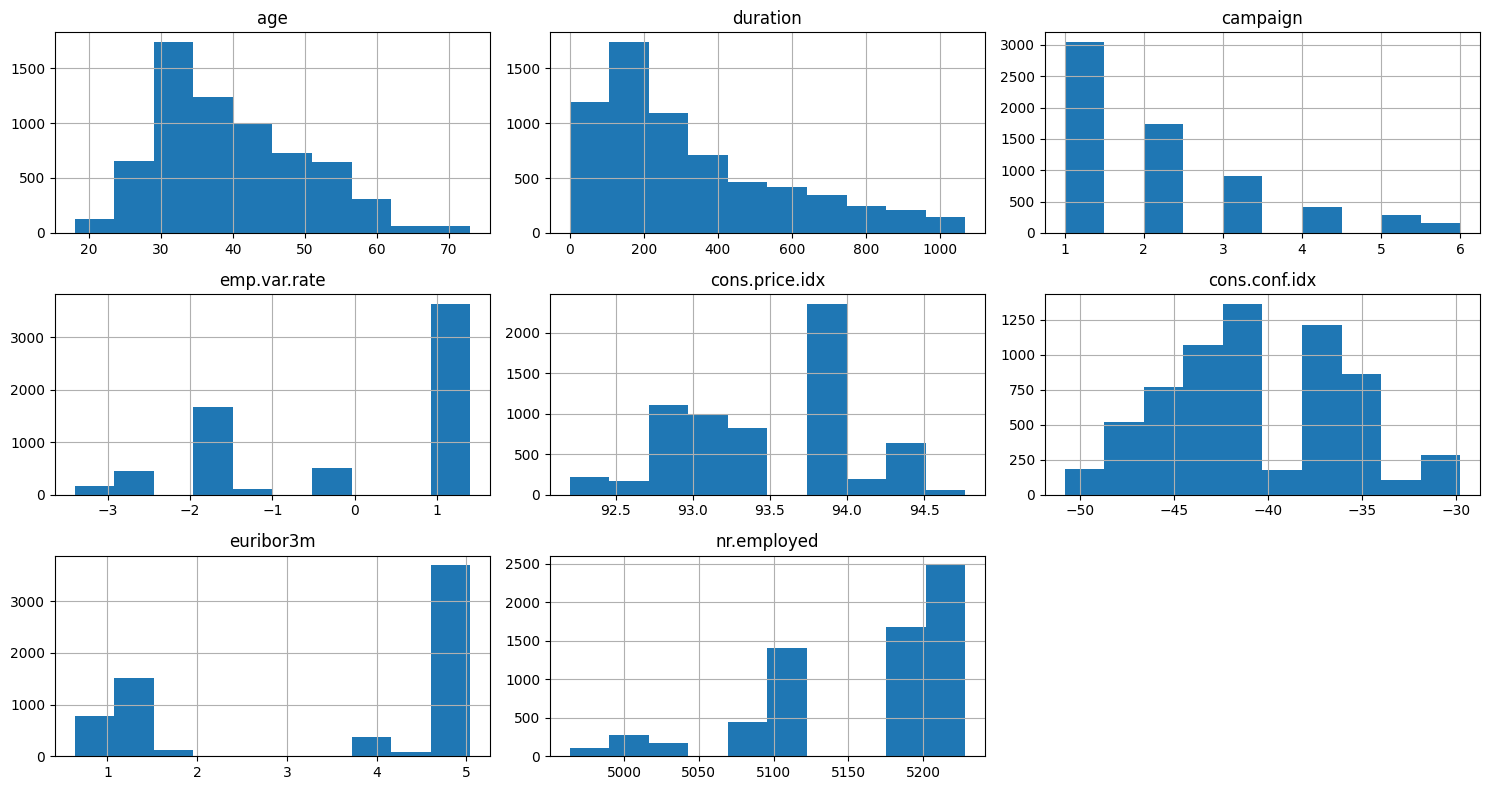

Skewness:


age               0.598601
duration          1.041608
campaign          1.324147
emp.var.rate     -0.575913
cons.price.idx   -0.214375
cons.conf.idx     0.104692
euribor3m        -0.545969
nr.employed      -0.880652
dtype: float64

In [ ]:
# for the independent numeric variables, we plot the histogram to check the distribution of the variables
# Note: the hist() function considers the numeric variables only, by default
# we drop the target variable using drop()
# 'axis=1' drops the specified column
df_feature.hist()

# adjust the subplots
plt.tight_layout()

# display the plot
plt.show()  

# print the skewness for each numeric independent variable
print('Skewness:')
# we drop the target variable using drop()
# 'axis=1' drops the specified column
# skew() returns the coefficient of skewness for each variable
df_feature.skew()

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>7. Plot the distribution of the target variable.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

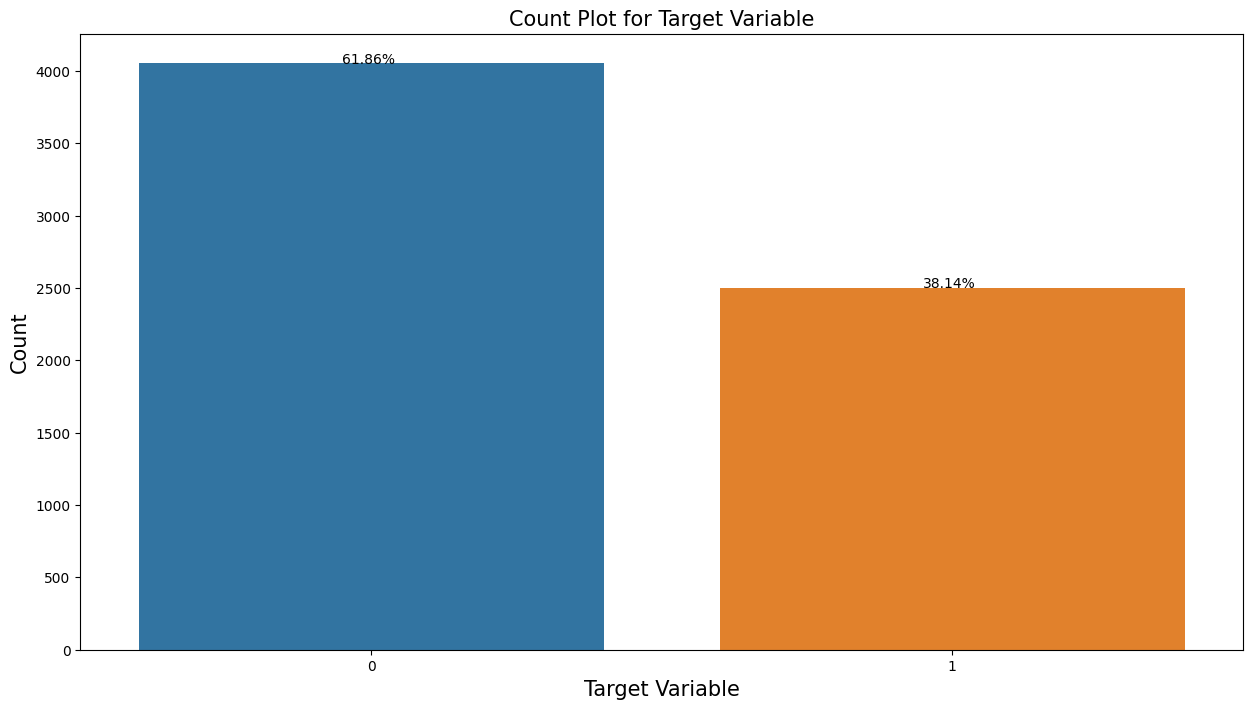

In [ ]:
# get counts of 0's and 1's in the target variable
df_target.value_counts()

# plot the countplot of the target variable
sns.countplot(x = df_target)

# use below code to print the values in the graph
# 'x' and 'y' gives position of the text
# 's' is the text 
plt.text(x = -0.05, y = df_target.value_counts()[0] + 1, s = str(round((df_target.value_counts()[0])*100/len(df_target),2)) + '%')
plt.text(x = 0.95, y = df_target.value_counts()[1] +1, s = str(round((df_target.value_counts()[1])*100/len(df_target),2)) + '%')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Count Plot for Target Variable', fontsize = 15)
plt.xlabel('Target Variable', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

# to show the plot
plt.show()

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>8. Scale all the numeric variables using standard scalar.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

We scale the variables to get all the variables in the same range. With this, we can avoid a problem in which some features come to dominate solely because they tend to have larger values than others.

In [63]:
df_feature_nb=df_feature.drop('age',axis=1)
df_feature_nb.head()

,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,205,2,1.100000,93.994000,-36.400000,4.858000,5191.000000
1,243,3,-1.800000,92.843000,-50.000000,1.531000,5099.100000
2,214,1,-0.100000,93.200000,-42.000000,4.120000,5195.800000
3,550,1,1.100000,93.994000,-36.400000,4.857000,5191.000000
4,64,1,1.100000,93.994000,-36.400000,4.855000,5191.000000


In [64]:
# initialize the standard scalar
X_scaler = StandardScaler()

# scale all the numerical columns
# standardize all the columns of the dataframe 'df_feature'
num_scaled = X_scaler.fit_transform(df_feature_nb)

# create a dataframe of scaled numerical variables
# pass the required column names to the parameter 'columns'
X = pd.DataFrame(num_scaled, columns = df_feature_nb.columns)

# display first five observations
X.head()

,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,-0.480765,-0.024486,0.701361,0.749298,0.910658,0.765585,0.394074
1,-0.330797,0.754670,-1.081276,-1.217928,-2.008221,-1.104009,-0.840708
2,-0.445246,-0.803642,-0.036282,-0.607764,-0.291233,0.350869,0.458567
3,0.880787,-0.803642,0.701361,0.749298,0.910658,0.765023,0.394074
4,-1.037225,-0.803642,0.701361,0.749298,0.910658,0.763899,0.394074


<a id="knn"> </a>
## 2. K Nearest Neighbors (KNN)

## We shall use the bank marketing dataset that we cleaned above

Before applying classification techniques to predict whether the client subscribed the term deposit or not, let us split the dataset in train and test set.

In [ ]:
# split data into train subset and test subset
# set 'random_state' to generate the same dataset each time you run the code 
# 'test_size' returns the proportion of data to be included in the testing set
X_train, X_test, y_train, y_test = train_test_split(X, df_target, random_state = 10,test_size = 0.2)

# check the dimensions of the train & test subset using 'shape'
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (5244, 7)
y_train (5244,)
X_test (1311, 7)
y_test (1311,)


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>9. Create a function to draw a confusion matrix (heatmap) and a function to plot a roc-auc curve.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

#### Define a function to plot the confusion matrix.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# define a to plot a confusion matrix for the model
def plot_confusion_matrix(model):
    
    # predict the target values using X_test
    y_pred = model.predict(X_test)
    
    # create a confusion matrix
    # pass the actual and predicted target values to the confusion_matrix()
    cm = confusion_matrix(y_test, y_pred)

    # label the confusion matrix  
    # pass the matrix as 'data'
    # pass the required column names to the parameter, 'columns'
    # pass the required row names to the parameter, 'index'
    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], 
                               index = ['Actual:0','Actual:1'])

    # plot a heatmap to visualize the confusion matrix
    # 'annot' prints the value of each grid 
    # 'fmt = d' returns the integer value in each grid
    # 'cmap' assigns color to each grid
    # as we do not require different colors for each grid in the heatmap,
    # use 'ListedColormap' to assign the specified color to the grid
    # 'cbar = False' will not return the color bar to the right side of the heatmap
    # 'linewidths' assigns the width to the line that divides each grid
    # 'annot_kws = {'size':25})' assigns the font size of the annotated text 
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
                linewidths = 0.1, annot_kws = {'size':25})

    # set the font size of x-axis ticks using 'fontsize'
    plt.xticks(fontsize = 20)

    # set the font size of y-axis ticks using 'fontsize'
    plt.yticks(fontsize = 20)

    # display the plot
    plt.show()#### Define a function to plot the confusion matrix.

#### Define a function to plot the ROC curve.

In [ ]:
# define a function to plot the ROC curve and print the ROC-AUC score
def plot_roc(model):
    
    # predict the probability of target variable using X_test
    # consider the probability of positive class by subsetting with '[:,1]'
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    # pass the actual target values and predicted probabilities to the function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve for Admission Prediction Classifier', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.02, y = 0.9, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>10. Build a knn model on a training dataset with euclidean distance and 3 neighbours to predict whether or not the client subscribed the term deposit. Calculate the accuracy of the model.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
#By default KNN works as uniform mode of operation ( if weights='distance', it work as weighted mode)
# instantiate the 'KNeighborsClassifier'
# n_neighnors: number of neighbors to consider
# default metric is minkowski, and with p=2 it is equivalent to the euclidean metric
knn_classification = KNeighborsClassifier(n_neighbors = 3, metric='euclidean')

# fit the model using fit() on train data
knn_model = knn_classification.fit(X_train, y_train)

# predict the attrition for test set
y_pred = knn_model.predict(X_test)

# pass the actual and predicted target values to the accuracy_score()
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8520213577421816


In [ ]:
X_train.shape

(5244, 8)

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>11. Plot a confusion matrix using the function created above and print a classification report. </b>
                </font>
            </div>
        </td>
    </tr>
</table>

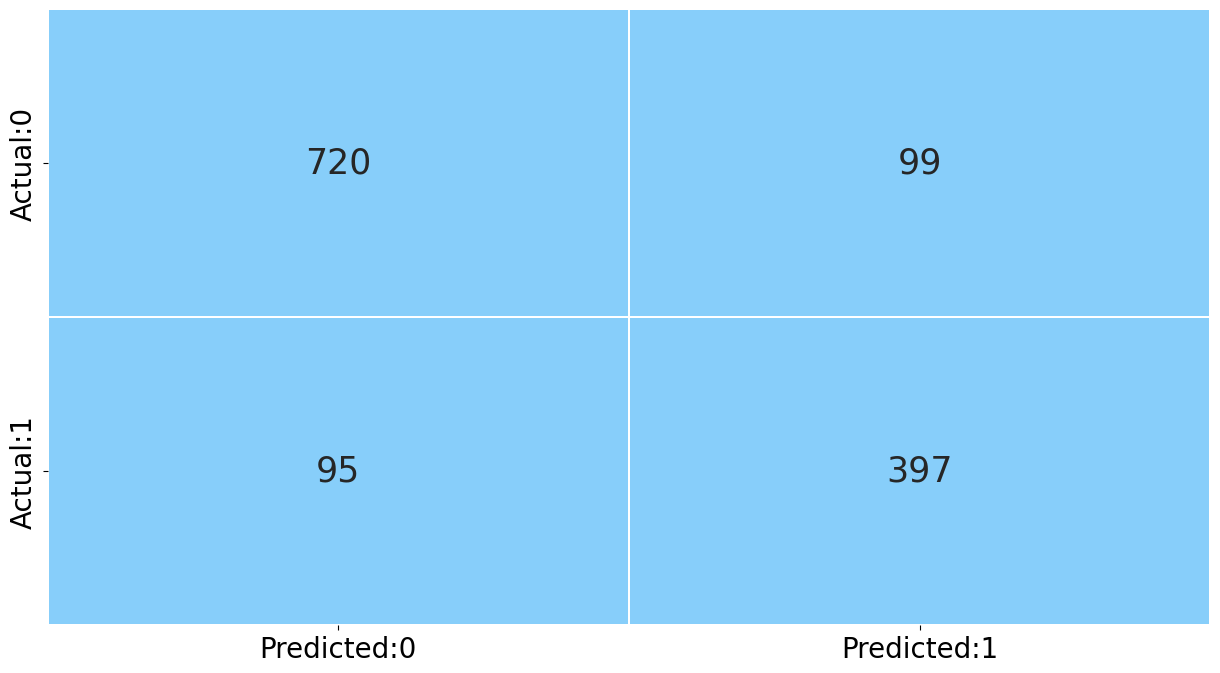

In [ ]:
# call the function to plot the confusion matrix
# pass the knn model to the function
plot_confusion_matrix(knn_model)

In [ ]:
# print the classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       819
           1       0.80      0.81      0.80       492

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311



In [ ]:
120/492,95/492

(0.24390243902439024, 0.19308943089430894)

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>12. Find the optimal value of 'k' in knn with 3 fold cross validation.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

Given list of values:

    n_neighbors = np.arange(1, 25, 2)
    metric = ['hamming','euclidean','manhattan','Chebyshev']

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
from pandas.core.common import random_state
from sklearn.utils import shuffle
# create a dictionary with hyperparameters and its values
# n_neighnors: number of neighbors to consider
# usually, we consider the odd value of 'n_neighnors' to avoid the equal number of nearest points with more than one class
# pass the different distance metrics to the parameter, 'metric'
hyp_paramaters = {'n_neighbors': np.arange(1, 250, 2),
                   'metric': ['hamming','euclidean','manhattan','Chebyshev'],
                  'weights':['uniform','distance']}
 
# instantiate the 'KNeighborsClassifier' 
knn_classification = KNeighborsClassifier(n_jobs=-1)

# use GridSearchCV() to find the optimal value of the hyperparameters
# estimator: pass the knn model
# param_grid: pass the list 'tuned_parameters'
# cv: number of folds in k-fold i.e. here cv = 3
kf=KFold(n_splits=10,shuffle=True,random_state=0)

knn_grid = GridSearchCV(estimator = knn_classification, 
                        param_grid = hyp_paramaters, 
                        cv = kf, 
                        scoring = 'roc_auc', 
                        n_jobs=-1)

# fit the model on X_train and y_train using fit()
knn_grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for KNN Classifier: ', knn_grid.best_params_, '\n')

Best parameters for KNN Classifier:  {'metric': 'euclidean', 'n_neighbors': 35, 'weights': 'uniform'} 



<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>13.  Build a KNN model with the best parameters and find the accuracy. Also generate a classification report.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
knn_grid.best_params_['n_neighbors']

47

In [ ]:
knn_grid.best_params_['metric']

'manhattan'

In [ ]:
knn_grid.best_params_['weights']

'distance'

In [ ]:
# instantiate the 'KNeighborsClassifier'
# n_neighnors: number of neighbors to consider
# default metric is minkowski, and with p=2 it is equivalent to the euclidean metric
knn_classification = KNeighborsClassifier(n_neighbors =35,metric='euclidean',weights='uniform')

# fit the model using fit() on train data
knn_model = knn_classification.fit(X_train, y_train)

# predict the attrition for test set
y_pred = knn_model.predict(X_test)

# pass the actual and predicted target values to the accuracy_score()
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8665141113653699


In [ ]:
# print the classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       819
           1       0.79      0.88      0.83       492

    accuracy                           0.87      1311
   macro avg       0.86      0.87      0.86      1311
weighted avg       0.87      0.87      0.87      1311



In [ ]:
confusion_matrix(y_test, y_pred)

array([[704, 115],
       [ 60, 432]])

In [ ]:
60/492

0.12195121951219512

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>14. Find the area under the receiver operating characteristic curve and the confusion matrix for the tuned KNN model built in question 13.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

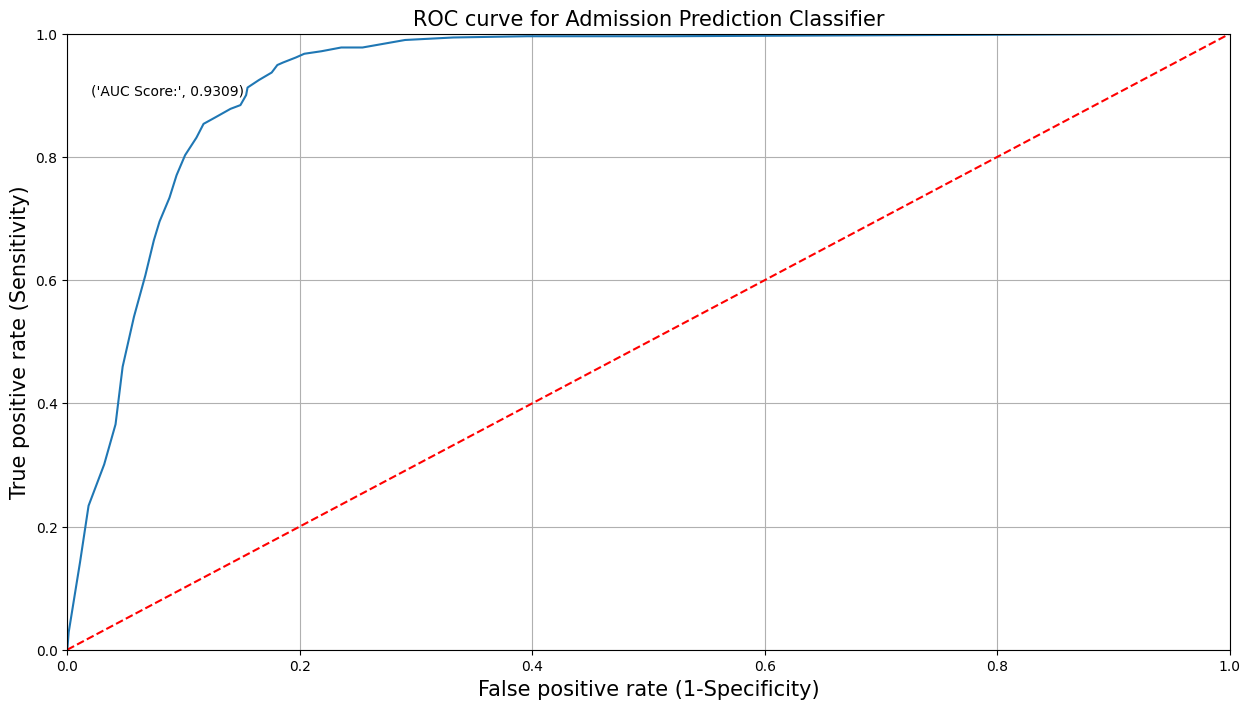

In [ ]:
# plot the ROC curve
plot_roc(knn_classification)

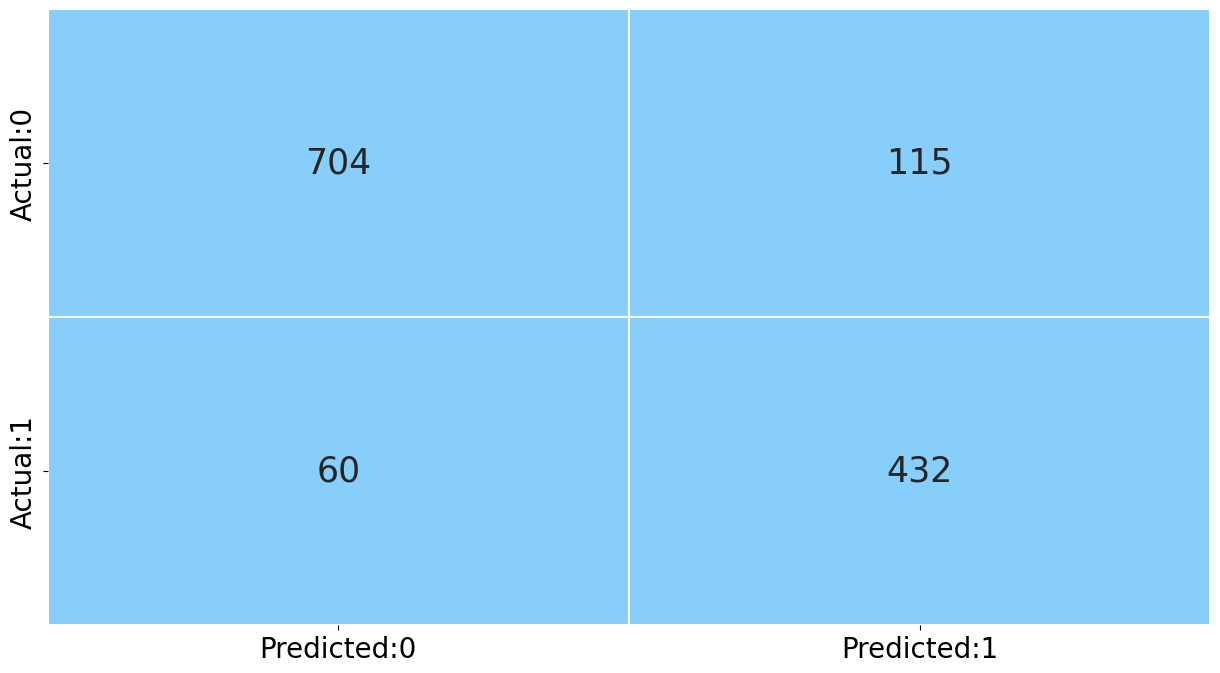

In [ ]:
# call the function to plot the confusion matrix
# pass the knn model to the function
plot_confusion_matrix(knn_classification)

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>15. Calculate the percentage of misclassified and correctly classified observations.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
cm = confusion_matrix(y_pred, y_test)

total = cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0]

# find the percentage of correctly classified observations
# round the result upto 2 decimal points
correct_classified_percentage = ((cm[0][0]+cm[1][1])/total)*100
print("Percentage of correctly classified observations: ", round(correct_classified_percentage, 2))

# find the percentage of  misclassified observations
# round the result upto 2 decimal points
misclassified_percentage = ((cm[0][1]+cm[1][0])/total)*100
print("Percentage of misclassified observations: ", round(misclassified_percentage, 2))

Percentage of correctly classified observations:  86.27
Percentage of misclassified observations:  13.73


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>16. Compute the accuracy for each value of k and append the value in a list 'accuracy'. Build knn models for euclidean distance metric. Consider only the odd numbers between the range 1 and 25 for the 'k'.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
# consider an empty list to store the accuracy
accuracy = []

# use for loop to build a knn model for each K
for i in np.arange(1,25,2):
    
    # setup a knn classifier with k neighbors
    # use the 'euclidean' metric 
    knn = KNeighborsClassifier(i, metric = 'euclidean', n_jobs=-1)
   
    # fit the model using 'cross_val_score'
    # pass the knn model as 'estimator'
    # use 3-fold cross validation
    score = cross_val_score(knn, X_train, y_train, cv = 3, n_jobs=-1)
    
    # calculate the mean score
    score = score.mean()
    
    # append the accuracy 
    accuracy.append(score)

In [ ]:
# print the accuracy score
accuracy

[0.8249427917620137,
 0.8499237223493518,
 0.8579328756674295,
 0.8636536994660564,
 0.8680396643783371,
 0.8665141113653699,
 0.8640350877192983,
 0.866323417238749,
 0.8668954996186118,
 0.8668954996186118,
 0.8646071700991609,
 0.8649885583524028]

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>17. Draw a line plot to see the accuracy (list created in the above question) for each value of K using euclidean distance as a metric of KNN model and find the optimal value of 'k'.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

Given list of values:

    n_neighbors = np.arange(1, 25, 2)

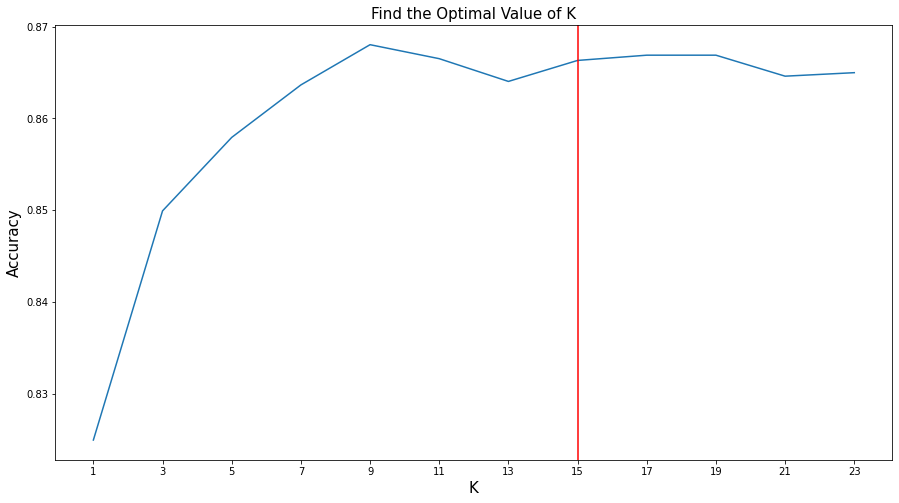

In [ ]:
# plot the accuracy for different values of K 
plt.plot(range(1,25,2), accuracy)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Find the Optimal Value of K', fontsize = 15)
plt.xlabel('K', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)

# set the x-axis labels
plt.xticks(np.arange(1, 25, step = 2))

# plot a vertical line across the minimum error rate
plt.axvline(x = 15, color = 'red')

# display the plot
plt.show()

**Intrepretation:** The accuracy is stabilized after k = 15. Thus, we can consider 15 as the optimal value of k.

In [ ]:
#Compare Logistic Regression model vs KNN model using KFold cross validation using roc_auc

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LR=LogisticRegression()
KNN_final=KNeighborsClassifier(n_neighbors=47,metric='manhattan',weights='distance')

In [ ]:
from sklearn.model_selection import KFold,cross_val_score

In [ ]:
knn=KNeighborsClassifier()
kf=KFold(n_splits=5,shuffle=True,random_state=0)
GS=GridSearchCV(knn,hyp_paramaters,cv=kf,scoring='roc_auc')
GS.fit(X,df_target)
GS.best_params_

{'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'uniform'}

In [ ]:
#Logistic
kf=KFold(n_splits=10,shuffle=True,random_state=0)
scores=cross_val_score(LR,X,df_target,cv=kf,scoring='roc_auc')
print("Bias_error",np.mean(scores))
print("Variance_error",np.std(scores,ddof=1))

Bias_error 0.9218855126445149
Variance_error 0.009520303164951989


In [ ]:
scores

array([0.91871441, 0.93208857, 0.93391424, 0.90836717, 0.92897415,
       0.90624273, 0.91925747, 0.92269608, 0.92977561, 0.91882469])

In [ ]:
#KNN
kf=KFold(n_splits=10,shuffle=True,random_state=0)
scores=cross_val_score(KNN_final,X,df_target,cv=kf,scoring='roc_auc')
print("Bias_error",np.mean(scores))
print("Variance_error",np.std(scores,ddof=1))

Bias_error 0.934249669706652
Variance_error 0.007923837631333657


In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
NB=GaussianNB()

In [ ]:
#NB
kf=KFold(n_splits=10,shuffle=True,random_state=0)
scores=cross_val_score(NB,X,df_target,cv=kf,scoring='roc_auc')
print("Bias_error",np.mean(scores))
print("Variance_error",np.std(scores,ddof=1))

Bias_error 0.8873754305035385
Variance_error 0.011544480787621285


In [ ]:
scores

array([0.88122444, 0.88986153, 0.89458817, 0.86444051, 0.89964443,
       0.88232327, 0.87782432, 0.89531205, 0.9029899 , 0.88554568])

<a id="nb"> </a>
## 3. Naive Bayes

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>18. Build a Gaussian naive bayes model and generate a classification report. Also tell how well is the model performing.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# instantiate the 'GaussianNB'
gnb = GaussianNB()

# fit the model using fit() on train data
gnb_model = gnb.fit(X_train, y_train)

# predict the attrition for test set
y_pred = gnb_model.predict(X_test)

# print the classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       819
           1       0.66      0.76      0.70       492

    accuracy                           0.76      1311
   macro avg       0.75      0.76      0.75      1311
weighted avg       0.77      0.76      0.76      1311



**Interpretation:** The recall for the positive class (i.e. customers who will subscribe) and the recall of the negative class (i.e. customers who will not subscribe) are stable.
Thus, we can say that our model is performing good.

Note: Recall for the positive class is also known as Sensitivity and Recall for the negative class is also known as Specificity.

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>19. Find the area under the receiver operating characteristic curve and the confusion matrix for the Naive Bayes model built in question 18.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

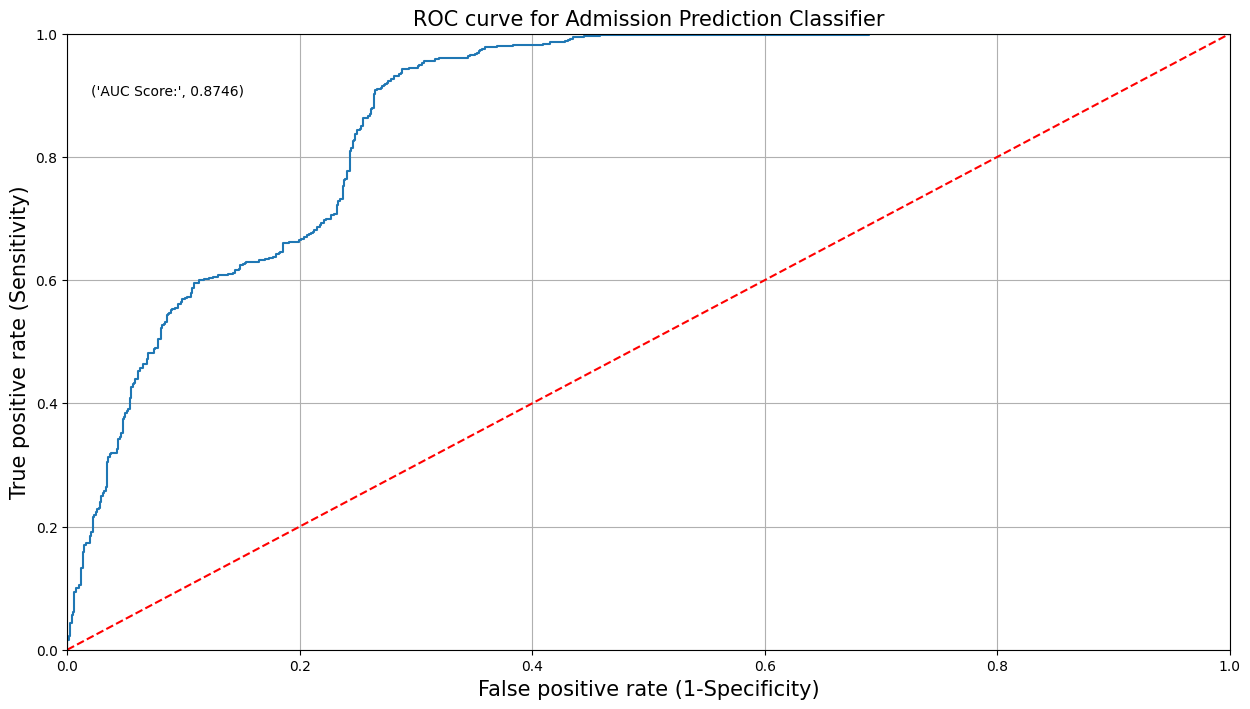

In [ ]:
# plot the ROC curve
plot_roc(gnb_model)

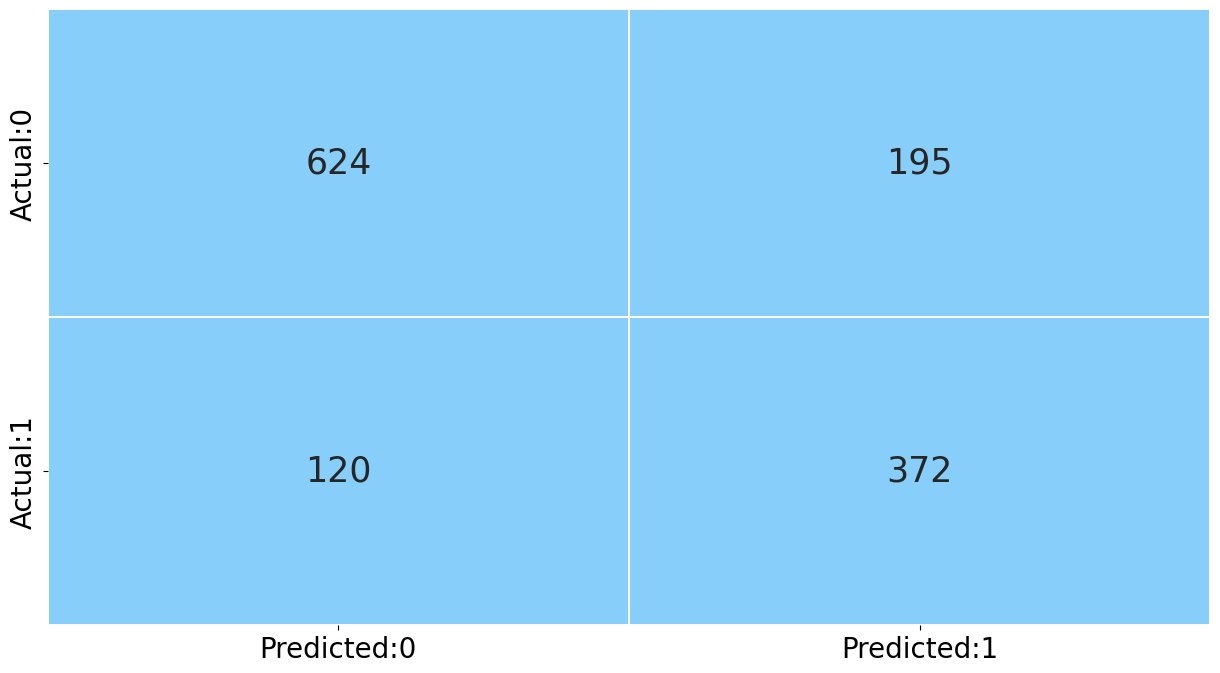

In [ ]:
# call the function to plot the confusion matrix
# pass the knn model to the function
plot_confusion_matrix(gnb_model)

In [ ]:
624/(624+120)

0.8387096774193549

In [ ]:
372/(372+195)

0.656084656084656

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>20. Build a Gaussian Naive Bayes model and perform 10 fold cross validation and find the average accuracy.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [ ]:
# instantiate the 'GaussianNB'
gnb = GaussianNB()
   
# fit the model using 'cross_val_score'
# pass the gnb model as 'estimator'
# use 10-fold cross validation
score = cross_val_score(gnb, X_train, y_train, cv = 10)

# calculate the mean score
score = score.mean()

print("Accuracy after 10 fold cross validation: ", round(score, 2))

Accuracy after 10 fold cross validation:  0.78


In [65]:
knn_tuned=KNeighborsClassifier(n_neighbors=35,metric='euclidean',weights='uniform')
NB=GaussianNB()

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
X.shape

(6555, 8)

In [66]:
kf=KFold(n_splits=10,shuffle=True,random_state=0)
scores=cross_val_score(knn_tuned,X,df_target,cv=kf,scoring='roc_auc')
print(np.mean(scores))
print(np.std(scores,ddof=1))

0.9359740291790184
0.0074589453213084345


In [ ]:
print(scores)

[0.93218558 0.93168073 0.94528786 0.91958003 0.93227448 0.91851284
 0.93558885 0.93734336 0.93361333 0.92770864]


In [67]:
scores=cross_val_score(NB,X,df_target,cv=kf,scoring='roc_auc')
print(np.mean(scores))
print(np.std(scores,ddof=1))

0.8873754305035385
0.011544480787621285


In [ ]:
print(scores)

[0.88194099 0.89119449 0.89649459 0.86474207 0.90198216 0.88337084
 0.88021356 0.89577427 0.9039787  0.88458272]
